In [3]:
import autograd.numpy as np
from autograd import grad
from numpy.lib.stride_tricks import sliding_window_view
import scipy.io
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from opt_einsum import contract

In [4]:
# create a set of fake traces (don't even need digraph, just do it) that has interesting dynamics

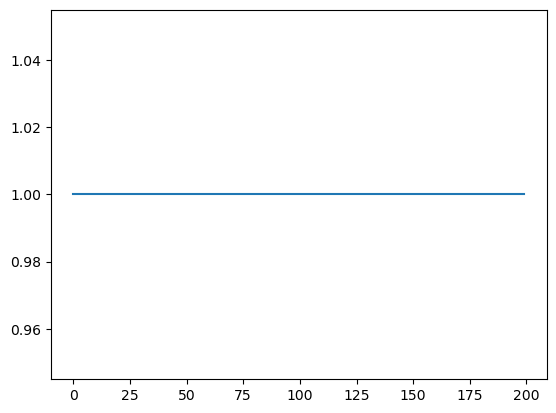

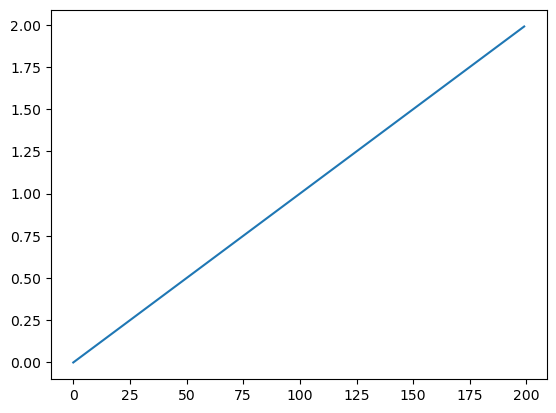

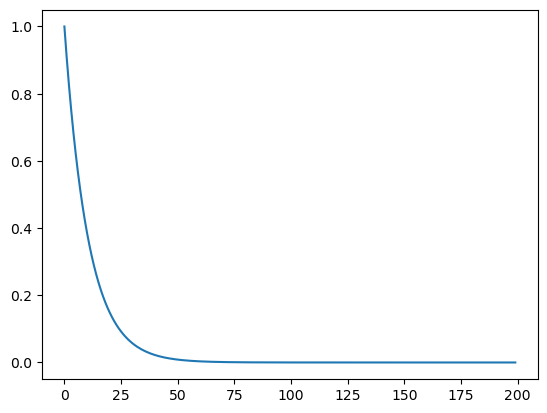

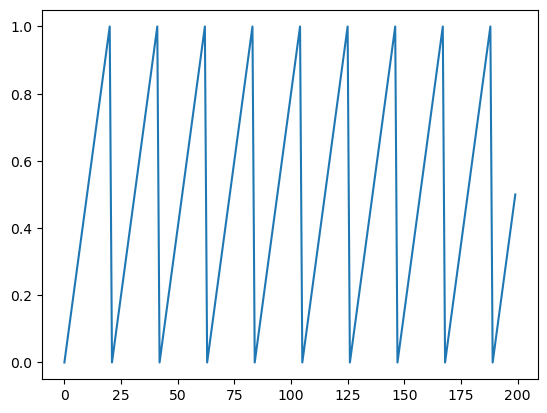

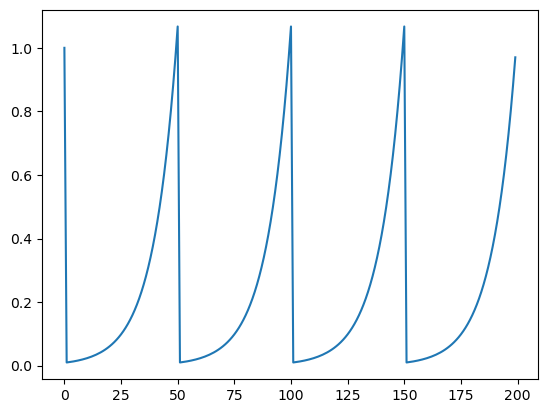

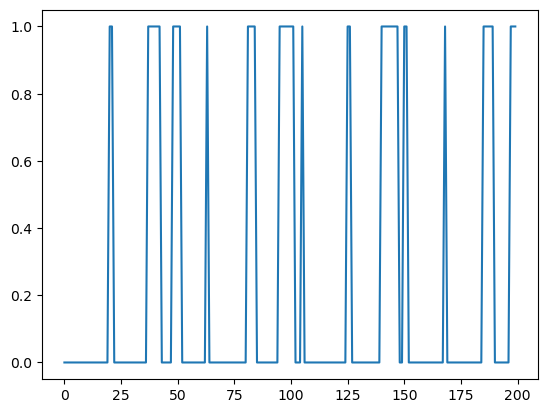

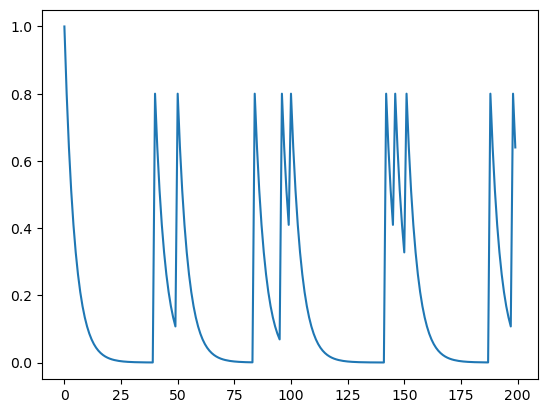

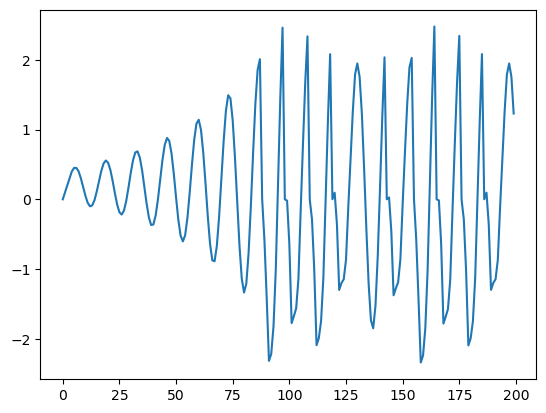

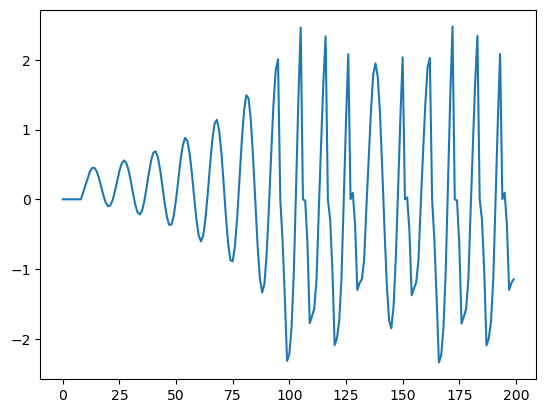

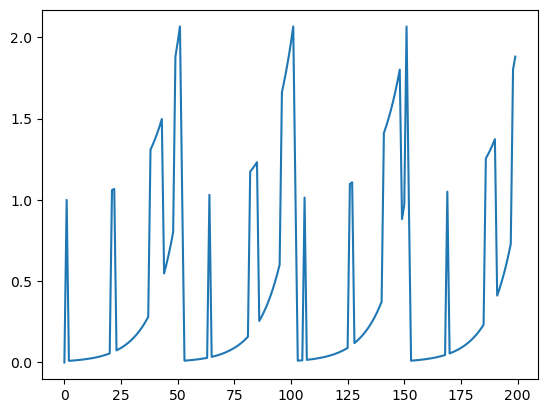

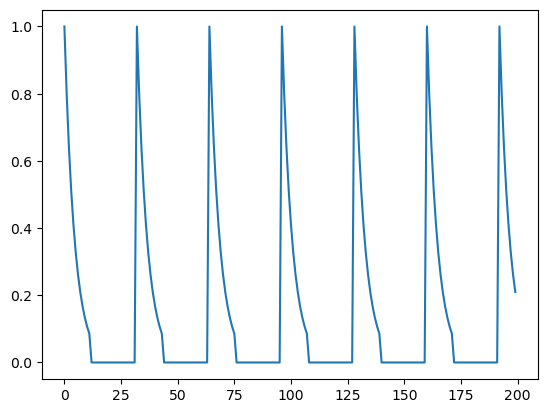

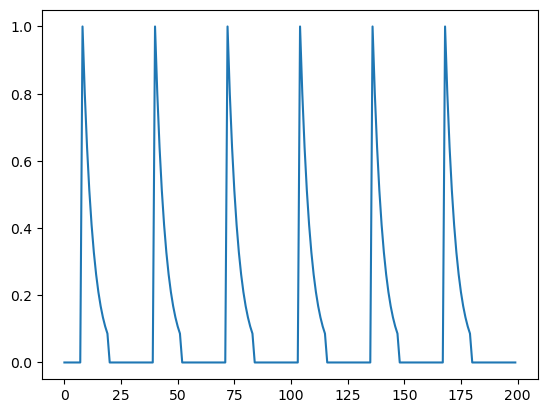

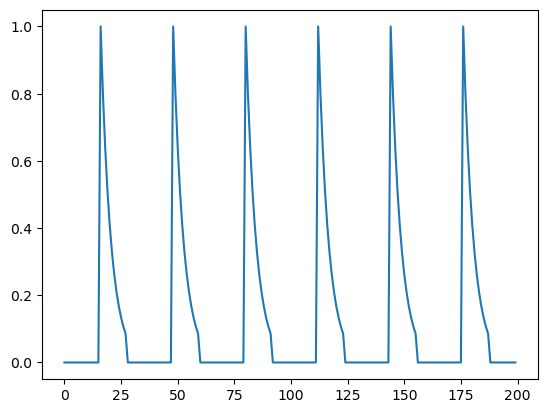

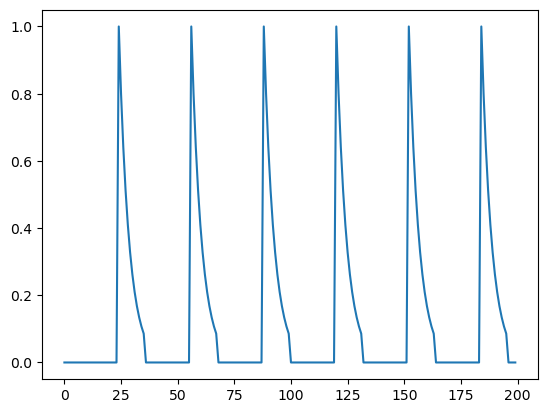

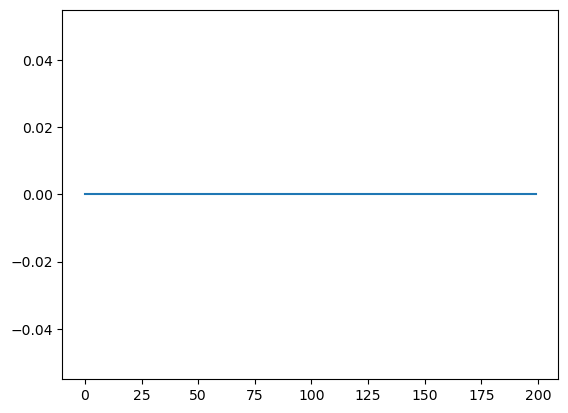

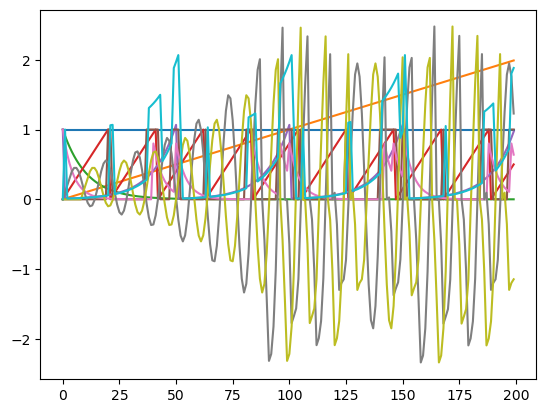

In [5]:
nodes = np.zeros((15,200))

nodes[0,0] = 1
nodes[2,0] = 1
nodes[4,0] = 1
nodes[6,0] = 1
nodes[7,0] = 0
nodes[10,0] = 1

for t in range(1, nodes.shape[1]):
    nodes[0,t] = 1

    nodes[1,t] = nodes[1,t-1] + 0.01
    nodes[2,t] = nodes[2,t-1] / 1.1

    nodes[3,t] = (0 if nodes[3,t-1] >= 1 else nodes[3,t-1] + 0.05)
    nodes[4,t] = (0.01 if nodes[4,t-1] >= 1 else 1.1*nodes[4,t-1])
    nodes[5,t] = 1 if sum([nodes[i,t-1] for i in range(3,5)]) > 1 else 0
    nodes[6,t] = 0.8 if nodes[6,t-1] < 0.5 and sum([nodes[i,t-1] for i in range(3,5)]) > 1.2 else nodes[6,t-1]*0.8

    nodes[7,t] = (0 if nodes[7,t-1] >= 2 else nodes[7,t-1] - 0.5*nodes[7,t-4] + 0.1)
    nodes[8,t] = nodes[7,t-8]

    nodes[9,t] = sum([nodes[i,t-1] for i in range(4,6)])

    nodes[10,t] = 0.8*nodes[10,t-1] if nodes[10,t-1] >=0.1 else nodes[13,t-8] 
    nodes[11,t] = nodes[10,t-8]
    nodes[12,t] = nodes[11,t-8]
    nodes[13,t] = nodes[12,t-8]

    nodes[14,t] = nodes[14,t-3]

x = np.arange(nodes.shape[1])
y = [nodes[i,:] for i in range(nodes.shape[0])]
for i in range(nodes.shape[0]):
    plt.plot(x,y[i])
    plt.show()
plt.plot(
    x,y[0], 
    x,y[1], 
    x,y[2], 
    x,y[3], 
    x,y[4], 
    x,y[5], 
    x,y[6], 
    x,y[7], 
    x,y[8], 
    x,y[9]
    )
plt.show()

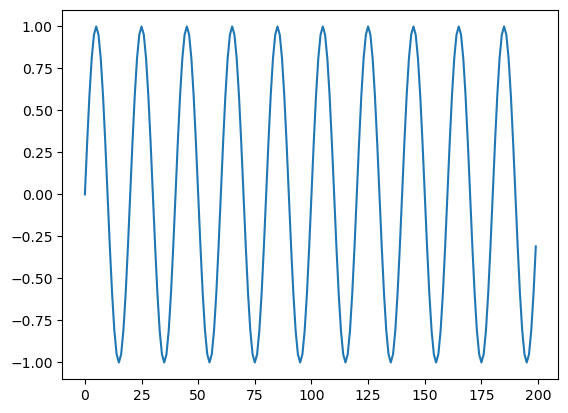

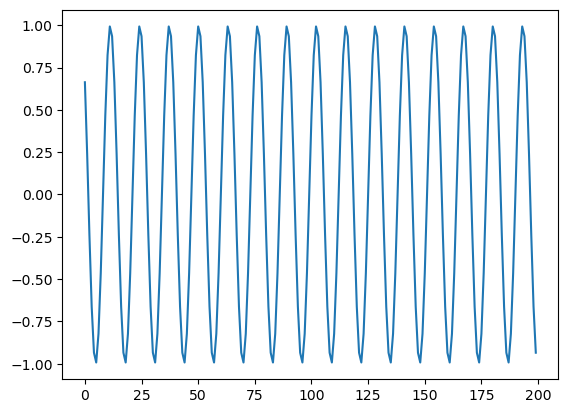

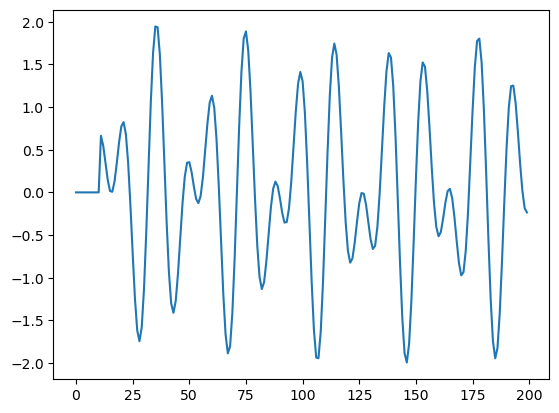

In [6]:
edge_list = [
    ('S1', 'N1', 1), 
    ('S2', 'N1', 1)
]

connectome = nx.DiGraph()
connectome.add_weighted_edges_from(edge_list)

# Don't attempt to fit sensory nodes
T = 200
wavelength_1 = 20
phase_1 = 0
wavelength_2 = 13
phase_2 = 5
delay = 11

S1_trace = np.fromfunction(lambda t: np.sin((t+phase_1)*(2*np.pi)/wavelength_1), (T,), dtype=float)
S2_trace = np.fromfunction(lambda t: np.sin((t+phase_2)*(2*np.pi)/wavelength_2), (T,), dtype=float)
N1_trace = np.concatenate((np.zeros(delay), (S1_trace + S2_trace)[:-11]))
traces = np.stack((S1_trace, S2_trace, N1_trace))

for neuron in range(traces.shape[0]):
    plt.plot(np.arange(T),traces[neuron,:])
    plt.show()

In [7]:
a = np.random.randint(10, size=20)
print(a)
print(a[[1,1,2,4] + [0]*100])
b = np.random.randint(2, size=20).astype(bool)
print(b)
print(a[b])

[1 6 6 0 8 8 3 0 5 4 3 5 8 4 2 9 0 3 3 4]
[6 6 6 8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ True False False  True False  True  True  True False  True  True False
 False  True  True False  True False  True  True]
[1 0 8 3 0 4 3 4 2 0 3 4]


In [8]:
x_rel = np.random.randint(10, size=(6,7,20))
C = np.random.randint(10, size=(7,20,1,4))
x_self = x_rel[:,:1,-4:]

print(x_rel.shape)
print(x_self.shape)
print(C.shape)

c = contract("ijk,jklm,ilm->i", x_rel, C, x_self)
print(c)


(6, 7, 20)
(6, 1, 4)
(7, 20, 1, 4)
[18420 35126 67458 65690 42907 71812]


In [9]:
def loss(expected, predicted):
    return np.linalg.norm(expected - predicted)

In [11]:
# traces = defined above
relevant_mask = np.array([True,True,True])
relevant_count = np.count_nonzero(relevant_mask)
self_mask = np.array([False,False,True])
W = traces.shape[1]
w_rr = 10
w_sr = 2 # must be at most w_rr
num_windows = W - w_rr + 1

relevant_sliding_window = np.squeeze(sliding_window_view(traces[relevant_mask,:], (relevant_count, w_rr), writeable=False), axis=0)
self_sliding_window = np.squeeze(sliding_window_view(traces[self_mask,w_rr-w_sr:], (1, w_sr), writeable=False), axis=0)


def make_prediction(C):
    return contract("ijk,jklm,ilm->i", relevant_sliding_window, C, self_sliding_window)

# g = grad(make_prediction)

C = np.random.random(size=(relevant_count,w_rr,1,w_sr))
# print(g(C))

print(traces.shape)
print(relevant_sliding_window.shape)
print(self_sliding_window.shape)
print(C.shape)

# print(np.tensordot(relevant_sliding_window, np.broadcast_to(C, (num_windows,relevant_count,w_rr,1,w_sr)), axes=([1,2],[1,2])).shape)
# print(np.tensordot(np.tensordot(relevant_sliding_window, C, axes=([1,2],[0,1])), self_sliding_window, axes=([1,2],[1,2])).shape)
prediction = contract("ijk,jklm,ilm->i", relevant_sliding_window, C, self_sliding_window, )
print(prediction.shape)


(3, 200)
(191, 3, 10)
(191, 1, 2)
(3, 10, 1, 2)
(191,)


In [ ]:
# T - total time of sample collection
# W - width of window we're attempting to fit
# w_rr - width of relevant retention window
# w_sr - width of self-retention window

# n - number of neurons
# x - trace data matrix [n x T]
# N(i) = neighbors of neuron i (S(i) = successors, P(i) = predecessors)
# C_i - coefficient matrix for neuron i [(1 + |N(i)|) x ]
# Calculate x[i,t] = x[[i] + N(i), t-w_rr:t].T @ C_i @ x[i, t-w_sr:t]


x_rel = S1_trace

np.tensordot(np.tensordot(x_rel, C, axes=([0,1],[0,1])), x_self, axes=([0,1],[0,1]))
np.tensordot(np.tensordot(x_rel, C, axes=([0,1],[0,1])), x_self, axes=([0,1],[0,1]))